# Implementing a Recommender System with SageMaker, Tensfolow, and Keras

## Model: dense_1_Multiply_50_embeddings_4_epochs_dropout

## _**Making Product - Shoes Recommendations Using Neural Networks and Embeddings**_


## Background

#### In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

#### Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

#### Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](./images/1_PefuBiYr9Bp7lo_zotGj0Q.png)

### ** Matrix factorization has been extended and genarlized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon dataset.  It will start by exploring our data in the notebook and even training a model on a sample of the data.  Later we'll expand to the full dataset and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.

---

## Setup

#### _This notebook was created and tested on an ml.p2.xlarge notebook instance._

#### Let's start by specifying:

#### - The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
#### - The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

---

Frame the recommendation system as a rating prediction machine learning problem and create a hybrid architecture that mixes the collaborative and content based filtering approaches:
- Collaborative part: Predict items ratings in order to recommend to the user items that he is likely to rate high.
- Content based: use metadata inputs (such as price and title) about items to find similar items to recommend.

### - Create 2 explicit recommendation engine models based on 2 machine learning architecture using Keras: 
    1. a matrix factorization model  
    2. a deep neural network model.


### Compare the results of the different models and configurations to find the "best" predicting model

### Used the best model for recommending items to users

In [1]:
### name of model
modname = 'dense_1_Multiply_50_embeddings_4_epochs_dropout'

### size of embedding
embedding_size = 50

### number of epochs
num_epochs = 4

In [2]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install sagemaker-experiments
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install boto3
!{sys.executable} -m pip install sagemaker
!{sys.executable} -m pip install pyspark
!{sys.executable} -m pip install ipython-autotime
!{sys.executable} -m pip install surprise
!{sys.executable} -m pip install smart_open
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install fastparquet

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (20.1.1)


In [3]:
# Check Jave version 
# !sudo yum -y update

In [4]:
# Need to use Java 1.8.0
!sudo yum remove jre-1.7.0-openjdk -y

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
No Match for argument: jre-1.7.0-openjdk
No Packages marked for removal


In [5]:
!java -version

openjdk version "11.0.1" 2018-10-16 LTS
OpenJDK Runtime Environment Zulu11.2+3 (build 11.0.1+13-LTS)
OpenJDK 64-Bit Server VM Zulu11.2+3 (build 11.0.1+13-LTS, mixed mode)


In [6]:
# !sudo update-alternatives --config java

In [7]:
!pip install pyarrow fastparquet

In [8]:
!pip install ipython-autotime

In [9]:
!pip install tqdm pydot pydotplus pydot_ng

In [10]:
#### To measure all running time
# https://github.com/cpcloud/ipython-autotime

%load_ext autotime

In [11]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np
from pandas import DataFrame 
import string
import pydot 
import pydotplus
import pydot_ng
import pickle
import time
import gzip
import os
os.getcwd()
    
import matplotlib.pyplot as plt
from math import floor,ceil

#from nltk.corpus import stopwords
#stop = stopwords.words("english")
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc,classification_report, mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection  import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from IPython.display import SVG

# Tensorflow
import tensorflow as tf

#Keras
from keras.models import Sequential, Model, load_model, save_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot, Concatenate
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib

time: 2.69 s


Using TensorFlow backend.


In [12]:
import pandas as pd

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

import gzip
import json

from pyspark.ml import Pipeline
from pyspark.sql.types import StructField, StructType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.evaluation import RegressionEvaluator

import os
import pandas as pd
import pyarrow
import fastparquet

# from pandas_profiling import ProfileReport

time: 366 ms


### Set and Check GPUs

In [13]:
#Session
from keras import backend as K

def set_check_gpu():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction =1 # allow all of the GPU memory to be allocated
    # for 8 GPUs
    # cfg.gpu_options.visible_device_list = "0,1,2,3,4,5,6,7" # "0,1"
    # for 1 GPU
    cfg.gpu_options.visible_device_list = "0"
    #cfg.gpu_options.allow_growth = True  # # Don't pre-allocate memory; dynamically allocate the memory used on the GPU as-needed
    #cfg.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras

    print("* TF version: ", [tf.__version__, tf.test.is_gpu_available()])
    print("* List of GPU(s): ", tf.config.experimental.list_physical_devices() )
    print("* Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) 
  
    
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # set for 8 GPUs
#     os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7";
    # set for 1 GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "0";

    # Tf debugging option
    tf.debugging.set_log_device_placement(True)

    gpus = tf.config.experimental.list_physical_devices('GPU')

    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

#     print(tf.config.list_logical_devices('GPU'))
    print(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

time: 4.82 ms


In [14]:
set_check_gpu()

* TF version:  ['1.15.2', True]
* List of GPU(s):  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
* Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
time: 191 ms


In [15]:
# reset GPU memory& Keras Session
def reset_keras():
    try:
        del classifier
        del model    
    except:
        pass

    K.clear_session()
 
    K.get_session().close()
#    sess = K.get_session()

    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction 
#     cfg.gpu_options.visible_device_list = "0,1,2,3,4,5,6,7" # "0,1"
    cfg.gpu_options.visible_device_list = "0" # "0,1"
    cfg.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras
    

time: 2.14 ms


---
## Data - https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  
More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [16]:
!aws s3 ls s3://amazon-reviews-pds/tsv/

2017-11-24 13:22:50          0 
2017-11-24 13:48:03  241896005 amazon_reviews_multilingual_DE_v1_00.tsv.gz
2017-11-24 13:48:17   70583516 amazon_reviews_multilingual_FR_v1_00.tsv.gz
2017-11-24 13:48:34   94688992 amazon_reviews_multilingual_JP_v1_00.tsv.gz
2017-11-24 13:49:14  349370868 amazon_reviews_multilingual_UK_v1_00.tsv.gz
2017-11-24 13:48:47 1466965039 amazon_reviews_multilingual_US_v1_00.tsv.gz
2017-11-24 13:49:53  648641286 amazon_reviews_us_Apparel_v1_00.tsv.gz
2017-11-24 13:56:36  582145299 amazon_reviews_us_Automotive_v1_00.tsv.gz
2017-11-24 14:04:02  357392893 amazon_reviews_us_Baby_v1_00.tsv.gz
2017-11-24 14:08:11  914070021 amazon_reviews_us_Beauty_v1_00.tsv.gz
2017-11-24 14:17:41 2740337188 amazon_reviews_us_Books_v1_00.tsv.gz
2017-11-24 14:45:50 2692708591 amazon_reviews_us_Books_v1_01.tsv.gz
2017-11-24 15:10:21 1329539135 amazon_reviews_us_Books_v1_02.tsv.gz
2017-11-24 15:22:13  442653086 amazon_reviews_us_Camera_v1_00.tsv.gz
2017-11-24 15:27:13 2689739299 amazon_rev

In [17]:
!mkdir -p ../data
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz ../data

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz to ../data/amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 18.9 s


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [18]:
!ls -alh ../data

total 624M
drwxrwxr-x  3 ec2-user ec2-user 4.0K May 27 18:22 .
drwxrwxr-x 10 ec2-user ec2-user 4.0K May 27 18:07 ..
-rw-rw-r--  1 ec2-user ec2-user  12M May 27 18:10 amazon_reviews_us_Shoes_v1_00_help_voted_And_cut_lognTail.csv
-rw-rw-r--  1 ec2-user ec2-user 613M Nov 25  2017 amazon_reviews_us_Shoes_v1_00.tsv.gz
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 27 16:14 .ipynb_checkpoints
-rw-rw-r--  1 ec2-user ec2-user    0 May 27 16:14 save_data_here.txt
time: 124 ms


In [19]:
df = pd.read_csv('../data/amazon_reviews_us_Shoes_v1_00.tsv.gz', delimiter='\t', error_bad_lines=False)

b'Skipping line 54101: expected 15 fields, saw 22\nSkipping line 55857: expected 15 fields, saw 22\nSkipping line 60448: expected 15 fields, saw 22\n'
b'Skipping line 76918: expected 15 fields, saw 22\nSkipping line 87925: expected 15 fields, saw 22\nSkipping line 88500: expected 15 fields, saw 22\nSkipping line 114276: expected 15 fields, saw 22\nSkipping line 128751: expected 15 fields, saw 22\n'
b'Skipping line 136095: expected 15 fields, saw 22\nSkipping line 140007: expected 15 fields, saw 22\nSkipping line 177148: expected 15 fields, saw 22\nSkipping line 180087: expected 15 fields, saw 22\nSkipping line 183010: expected 15 fields, saw 22\nSkipping line 183949: expected 15 fields, saw 22\nSkipping line 192879: expected 15 fields, saw 22\n'
b'Skipping line 223261: expected 15 fields, saw 22\nSkipping line 240588: expected 15 fields, saw 22\nSkipping line 247955: expected 15 fields, saw 22\nSkipping line 249336: expected 15 fields, saw 22\nSkipping line 259363: expected 15 fields, 

time: 38.9 s


# ** Amazon product dataset data analysis 

We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case this products).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.  Including additional features in our recommendation system could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

### Because most people haven't use most products, and people rate fewer products than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [20]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,108364,R2NZXYIVCGB13W,B00XFBPOQG,448483263,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,45449350,R2EQ1TG9IT3OEQ,B00SW64Y9W,7853171,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31


time: 29.3 ms


In [21]:
# shape of data
df.shape

(4358820, 15)

time: 2.52 ms


In [22]:
# Describing the data set
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,4.358820e+06,4.358820e+06,4.358820e+06,4.358820e+06,4.358820e+06
mean,2.631178e+07,4.983149e+08,4.241249e+00,8.777460e-01,1.076503e+00
std,1.546916e+07,2.898457e+08,1.157505e+00,7.563358e+00,8.137539e+00
min,1.001700e+04,2.220000e+02,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.338500e+07,2.463836e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.445766e+07,4.976083e+08,5.000000e+00,0.000000e+00,0.000000e+00
75%,4.090312e+07,7.502587e+08,5.000000e+00,1.000000e+00,1.000000e+00
max,5.309657e+07,9.999999e+08,5.000000e+00,5.070000e+03,5.329000e+03


time: 886 ms


In [23]:
# checking if there is any null data or not
df.isnull().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          1
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       26
review_body          440
review_date           21
dtype: int64

time: 3.13 s


In [24]:
# remove numm data
df = df.dropna()

time: 4.05 s


In [25]:
df.head(n=3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31


time: 14.3 ms


In [26]:
# checking if there is any null data or not
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

time: 3.12 s


In [27]:
# Describing the data according to the ratings
df.groupby('star_rating').describe()

customer_id                                                    \
                  count          mean           std      min          25%   
star_rating                                                                 
1              231702.0  2.613264e+07  1.555256e+07  10216.0  13159540.00   
2              242368.0  2.728759e+07  1.524881e+07  10121.0  14220759.25   
3              403414.0  2.675237e+07  1.538036e+07  10017.0  13773124.75   
4              846151.0  2.642434e+07  1.545640e+07  10053.0  13493269.00   
5             2634698.0  2.613613e+07  1.549374e+07  10022.0  13235135.50   

                                                 product_parent                \
                    50%          75%         max          count          mean   
star_rating                                                                     
1            24184169.5  40816197.00  53096405.0       231702.0  4.972857e+08   
2            25811489.5  41616422.25  53096567.0       242368.0  4.992033e+08   
3            25079965.5  41269264.50  53096471.0       403414.0  4.976268e+08   
4            24626637.0  41006751.50  53096474.0       846151.0  4.983365e+08   
5            24214413.0  40719567.00  53096567.0      2634698.0  4.984187e+08   

             ... helpful_votes         total_votes                            \
             ...           75%     max       count      mean        std  min   
star_rating  ...                                                               
1            ...           1.0  2293.0    231702.0  2.729437  12.343236  0.0   
2            ...           1.0   769.0    242368.0  1.558164   6.155664  0.0   
3            ...           1.0   494.0    403414.0  1.178992   5.193058  0.0   
4            ...           0.0  1338.0    846151.0  0.896550   4.915773  0.0   
5            ...           0.0  5070.0   2634698.0  0.927385   8.966711  0.0   

                                    
             25%  50%  75%     max  
star_rating                         
1            0.0  1.0  2.0  2522.0  
2            0.0  0.0  1.0   799.0  
3            0.0  0.0  1.0   513.0  
4            0.0  0.0  1.0  1357.0  
5            0.0  0.0  1.0  5329.0  

[5 rows x 32 columns]

time: 3.09 s


In [28]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

time: 2.42 ms


In [29]:
df = df[['customer_id', 'product_id', 'star_rating', 'product_title', 'helpful_votes']]

time: 196 ms


## Select voted review only

In [30]:
df.shape

(4358333, 5)

time: 2.18 ms


In [31]:
df = df[df['helpful_votes'] > 0]
df.shape

(1106199, 5)

time: 174 ms


In [32]:
4358333-1106199

3252134

time: 2.21 ms


In [33]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00      1.0
0.01      1.0
0.02      1.0
0.03      1.0
0.04      1.0
0.05      1.0
0.10      1.0
0.25      1.0
0.50      1.0
0.75      1.0
0.90      2.0
0.95      2.0
0.96      3.0
0.97      3.0
0.98      3.0
0.99      5.0
1.00    102.0
Name: customer_id, dtype: float64
products
 0.00      1.0
0.01      1.0
0.02      1.0
0.03      1.0
0.04      1.0
0.05      1.0
0.10      1.0
0.25      1.0
0.50      1.0
0.75      1.0
0.90      2.0
0.95      3.0
0.96      4.0
0.97      5.0
0.98      6.0
0.99      8.0
1.00    317.0
Name: product_id, dtype: float64
time: 1.03 s




### Clean

#### As we can see, only about 5% of customers have rated 2 or more products, and only 10% of products have been rated by 2+ customers.

## Let's filter out this long tail.

In [34]:
customers = customers[customers >= 2]
products = products[products >= 2]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

time: 1.08 s


In [35]:
reduced_df.shape

(155509, 5)

time: 2.2 ms


In [36]:
reduced_df.to_csv('../data/amazon_reviews_us_Shoes_v1_00_help_voted_And_cut_lognTail.csv', index_label=False)

time: 1.09 s


In [37]:
!aws s3 cp ../data/amazon_reviews_us_Shoes_v1_00_help_voted_And_cut_lognTail.csv s3://dse-cohort5-group1/Keras-DeepRecommender-Shoes/data/amazon_reviews_us_Shoes_v1_00_help_voted_And_cut_lognTail.csv

upload: ../data/amazon_reviews_us_Shoes_v1_00_help_voted_And_cut_lognTail.csv to s3://dse-cohort5-group1/Keras-DeepRecommender-Shoes/data/amazon_reviews_us_Shoes_v1_00_help_voted_And_cut_lognTail.csv
time: 1.24 s


Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [38]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

time: 173 ms


Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [39]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
print(reduced_df.shape)
reduced_df.head()

(155509, 7)


,customer_id,product_id,star_rating,product_title,helpful_votes,user,item
0,50073594,B00FLH88CO,4,Norwegian Fleece Lined Winter Slippers,9,42802,77648
1,50073594,B00B3HW97Q,5,2 Pairs Foster Grant Womans Versa Polarized Su...,1,42802,17508
2,34778598,B00B3HW97Q,4,2 Pairs Foster Grant Womans Versa Polarized Su...,2,2744,17508
3,34778598,B0016P39OC,4,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,1,2744,1750
4,14227737,B0016P39OC,4,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,2,3227,1750


time: 267 ms


Thus I have 1069568 rows and 8 columns dataset.

## 2. Arrange and clean the data

Rearrange the columns by relevance and rename column names

In [40]:
review_data = reduced_df

time: 660 µs


In [41]:
review_data.columns

Index(['customer_id', 'product_id', 'star_rating', 'product_title',
       'helpful_votes', 'user', 'item'],
      dtype='object')

time: 2.83 ms


In [42]:
review_data = review_data[['customer_id', 'product_id', 'star_rating', 'product_title', 'helpful_votes', 'user', 'item']]

review_data.rename(columns={ 'star_rating': 'score','customer_id': 'user_id', 'user': 'user_name'}, inplace=True)

#the variables names after rename in the modified data frame
list(review_data)

['user_id',
 'product_id',
 'score',
 'product_title',
 'helpful_votes',
 'user_name',
 'item']

time: 90.8 ms


In [43]:
review_data.head(n=3)

,user_id,product_id,score,product_title,helpful_votes,user_name,item
0,50073594,B00FLH88CO,4,Norwegian Fleece Lined Winter Slippers,9,42802,77648
1,50073594,B00B3HW97Q,5,2 Pairs Foster Grant Womans Versa Polarized Su...,1,42802,17508
2,34778598,B00B3HW97Q,4,2 Pairs Foster Grant Womans Versa Polarized Su...,2,2744,17508


time: 8.8 ms


In [44]:
# review_data["score"]

time: 32.4 ms


In [45]:
# Ratings distribution using pandas:
review_data["score"] = review_data["score"].fillna(review_data["score"].median()) 
review_data["score"].describe()

count    155509.000000
mean          4.077198
std           1.267738
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: score, dtype: float64

time: 20.8 ms


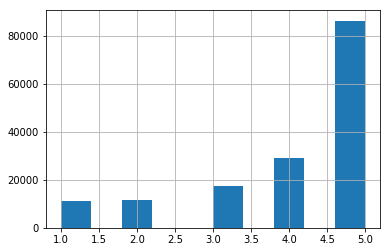

time: 261 ms


In [46]:
# Plot the distribution
review_data["score"].hist(bins=10)

## The median in both datasets is 5. This means that the data is skewed towards high ratings. 
This is a common bias in internet ratings, where people tend to rate items that they liked, and rarely spend time to comment something they dislike or are indiferent to. This will have a huge impact on the way I model the recommendation problem.

### Key conclusions from above: 

- Reviews are skewed towards positive
- Many people agree with score 5 reviews


### Arrange and clean the data

- Cleaning, handling missing data, normalization, etc:
- For the algorithm in keras to work,  remap all item_ids and user_ids to an interger between 0 and the total number of users or the total number of items

In [47]:
review_data.columns

Index(['user_id', 'product_id', 'score', 'product_title', 'helpful_votes',
       'user_name', 'item'],
      dtype='object')

time: 2.81 ms


In [48]:
review_data.head(n=2)

,user_id,product_id,score,product_title,helpful_votes,user_name,item
0,50073594,B00FLH88CO,4,Norwegian Fleece Lined Winter Slippers,9,42802,77648
1,50073594,B00B3HW97Q,5,2 Pairs Foster Grant Womans Versa Polarized Su...,1,42802,17508


time: 29.9 ms


In [49]:
items = review_data.product_id.unique()
item_map = {i:val for i,val in enumerate(items)}
inverse_item_map = {val:i for i,val in enumerate(items)}
review_data["old_item_id"] = review_data["product_id"] # copying for join with metadata
review_data["item_id"] = review_data["product_id"].map(inverse_item_map)
items = review_data.item_id.unique()
print ("We have %d unique items in metadata "%items.shape[0])

We have 97758 unique items in metadata 
time: 344 ms


In [50]:
users = review_data.user_id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
review_data["old_user_id"] = review_data["user_id"] 
review_data["user_id"] = review_data["user_id"].map(inverse_user_map)

items_reviewed = review_data.product_id.unique()
review_data["old_item_id"] = review_data["product_id"] # copying for join with metadata
review_data["item_id"] = review_data["product_id"].map(inverse_item_map)

items_reviewed = review_data.item_id.unique()
users = review_data.user_id.unique()
helpful_votes = review_data.helpful_votes.unique()



time: 514 ms


In [51]:
print ("We have %d unique users"%users.shape[0])
print ("We have %d unique items reviewed"%items_reviewed.shape[0])
# We have 192403 unique users in the "small" dataset
# We have 63001 unique items reviewed in the "small" dataset

We have 94852 unique users
We have 97758 unique items reviewed
time: 1.1 ms


#### We have 94852 unique users
#### We have 97758 unique items reviewed

In [52]:
review_data.head(3)

,user_id,product_id,score,product_title,helpful_votes,user_name,item,old_item_id,item_id,old_user_id
0,0,B00FLH88CO,4,Norwegian Fleece Lined Winter Slippers,9,42802,77648,B00FLH88CO,0,50073594
1,0,B00B3HW97Q,5,2 Pairs Foster Grant Womans Versa Polarized Su...,1,42802,17508,B00B3HW97Q,1,50073594
2,1,B00B3HW97Q,4,2 Pairs Foster Grant Womans Versa Polarized Su...,2,2744,17508,B00B3HW97Q,1,34778598


time: 10.8 ms


### Check the Distribution of number of ratings per user:

In [53]:
users_ratings = review_data['old_user_id'].value_counts().reset_index()
users_ratings.columns= ['old_user_id','num_ratings']
users_ratings['num_ratings'].describe()

count    94852.000000
mean         1.639491
std          1.057235
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         44.000000
Name: num_ratings, dtype: float64

time: 22.1 ms


### The distribution of number of ratings per user is very skewed in both datasets, with 50% of people having done a small number of reviews, and few made many ratings. 
### I will check if it gives us enough information for generating good recommendations.

### * Check the Distribution of the number of ratings per item:

In [54]:
review_data.columns

Index(['user_id', 'product_id', 'score', 'product_title', 'helpful_votes',
       'user_name', 'item', 'old_item_id', 'item_id', 'old_user_id'],
      dtype='object')

time: 2.32 ms


In [55]:
review_data.head(n=10)

,user_id,product_id,score,product_title,helpful_votes,user_name,item,old_item_id,item_id,old_user_id
0,0,B00FLH88CO,4,Norwegian Fleece Lined Winter Slippers,9,42802,77648,B00FLH88CO,0,50073594
1,0,B00B3HW97Q,5,2 Pairs Foster Grant Womans Versa Polarized Su...,1,42802,17508,B00B3HW97Q,1,50073594
2,1,B00B3HW97Q,4,2 Pairs Foster Grant Womans Versa Polarized Su...,2,2744,17508,B00B3HW97Q,1,34778598
3,1,B0016P39OC,4,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,1,2744,1750,B0016P39OC,2,34778598
4,2,B0016P39OC,4,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,2,3227,1750,B0016P39OC,2,14227737
5,3,B0016P39OC,4,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,1,53252,1750,B0016P39OC,2,16743527
6,4,B0016P39OC,1,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,1,728,1750,B0016P39OC,2,17063906
7,5,B0016P39OC,5,JiMarti AV5 Aviator Sunglasses Spring Hing Mir...,1,54852,1750,B0016P39OC,2,9759254
8,1,B007PBF00C,5,adidas Performance Men's GSG-9.7 Tactical Boot,10,2744,29965,B007PBF00C,3,34778598
9,6,B007PBF00C,1,adidas Performance Men's GSG-9.7 Tactical Boot,6,20817,29965,B007PBF00C,3,49094832


time: 71.2 ms


### To evaluate the model, I randomly separate the data into a training and test set. 

In [56]:
ratings_train, ratings_test = train_test_split( review_data, test_size=0.1, random_state=0)

time: 103 ms


In [57]:
ratings_train.shape

(139958, 10)

time: 3.04 ms


In [58]:
ratings_test.shape

(15551, 10)

time: 2.03 ms


In [59]:
ratings_train.head(n=2)

,user_id,product_id,score,product_title,helpful_votes,user_name,item,old_item_id,item_id,old_user_id
56271,33548,B006BU36NQ,1,FASH Limited Chic Hobo Handbag Glossy Texture ...,1,17073,26997,B006BU36NQ,25868,26975048
32973,20553,B00UO0G7HQ,2,Han's Men's WZ12004 Air Sole Non Slip & Oil Re...,1,36431,34471,B00UO0G7HQ,13593,37773310


time: 9.66 ms


# **Define embeddings
### The $\underline{embeddings}$ are low-dimensional hidden representations of users and items, 
### i.e. for each item I can find its properties and for each user I can encode how much they like those properties so I can determine attitudes or preferences of users by a small number of hidden factors 

### Throughout the training, I learn two new low-dimensional dense representations: one embedding for the users and another one for the items.


In [60]:
#  declare input embeddings to the model
#User input
user_id_input = Input(shape=[1], name='user')
#Item Input
item_id_input = Input(shape=[1], name='item')
#helpful_votes
helpful_votes_id_input = Input(shape=[1], name='helpful_votes')

# define the size of embeddings as a parameter
user_embedding_size = embedding_size # Check 5, 10 , 15, 20, 50
item_embedding_size = embedding_size # Check 5, 10 , 15, 20, 50
helpful_votes_embedding_size = embedding_size # Check 5, 10 , 15, 20, 50


# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, input_dim=users.shape[0],
                               input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=item_embedding_size, input_dim=items_reviewed.shape[0],
                               input_length=1, name='item_embedding')(item_id_input)

helpful_votes_embedding = Embedding(output_dim=helpful_votes_embedding_size, input_dim=helpful_votes.shape[0],
                           input_length=1, name='price_embedding')(helpful_votes_id_input)



# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size). 
user_vecs = Reshape([user_embedding_size])(user_embedding)
user_vecs = Dense(128, activation='relu')(user_vecs)
item_vecs = Reshape([item_embedding_size])(item_embedding)
item_vecs = Dense(128, activation='relu')(item_vecs)
helpful_votes_vecs = Reshape([helpful_votes_embedding_size])(helpful_votes_embedding)
helpful_votes_vecs = Dense(128, activation='relu')(helpful_votes_vecs)





time: 110 ms


# 2. Deep Recommender

### Instead of taking a dot product of the user and the item embedding, concatenate or multiply them and use them as features for a neural network. 
### Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.

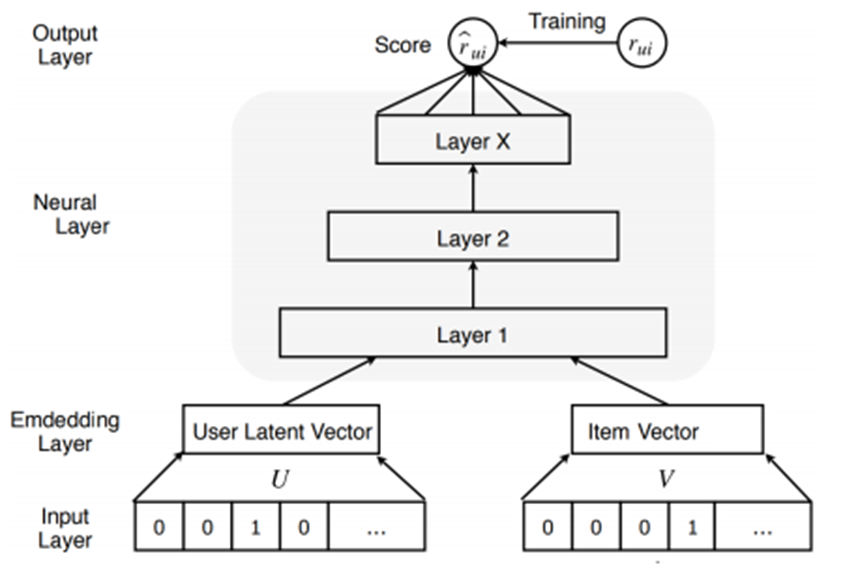






In [61]:
!mkdir -p ../models

time: 197 ms


In [62]:
# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation='relu')(user_vecs)
user_vecs = Dropout(0.4)(user_vecs)
item_vecs = Dense(64, activation='relu')(item_vecs)
item_vecs = Dropout(0.4)(item_vecs)
helpful_votes_vecs = Dense(64, activation='relu')(helpful_votes_vecs)
item_vecs = Dropout(0.4)(item_vecs)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
time: 94.6 ms


In [63]:
# Concatenate the item embeddings :
# item_vecs_complete  = Concatenate()([item_vecs, helpful_votes_vecs])

# Concatenate user and item embeddings and use them as features for the neural network:
# input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply
#input_vecs = Concatenate()([user_vecs, item_vecs]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network:
input_vecs = Multiply()([user_vecs, item_vecs]) # can be changed by concat 

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.4)(input_vecs)  

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.4)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not 
# x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
# x = Dense(64, activation='relu')(x) # Add dense again or not 
# x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
# x = Dense(32, activation='relu')(x) # Add dense again or not #
# x = Dropout(0.4)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

time: 58.2 ms


In [64]:
# create model
model = Model(inputs=
                    [
                     user_id_input,
                     item_id_input
                    ], 
              outputs=y)


# compile model
model.compile(loss='mse',
              optimizer="adam" )

# set save location for model
save_path = "../models"
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

# fit model - increate batch_size to 64
history = model.fit([ratings_train["user_id"]
                    , ratings_train["item_id"]
                    ]
                    , ratings_train["score"]
                    , batch_size=64
                    , epochs=num_epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)




Train on 125962 samples, validate on 13996 samples
Epoch 1/4




125962/125962 [==============================] - 34s 267us/step - loss: 2.2345 - val_loss: 1.5732
Epoch 2/4
125962/125962 [==============================] - 11s 86us/step - loss: 1.3091 - val_loss: 1.6494
Epoch 3/4
125962/125962 [==============================] - 11s 86us/step - loss: 1.0335 - val_loss: 1.6921
Epoch 4/4
125962/125962 [==============================] - 11s 86us/step - loss: 0.8895 - val_loss: 1.7337
time: 1min 7s


In [65]:
!mkdir -p ../histories

time: 206 ms


In [66]:
# Save the fitted model history to a file
with open('../histories/' + modname + '.pkl' , 'wb') as file_pi:  pickle.dump(history.history, file_pi)
    
print("Save history in ", '../histories/' + modname + '.pkl')

Save history in  ../histories/dense_1_Multiply_50_embeddings_4_epochs_dropout.pkl
time: 2.12 ms


In [67]:
def disp_model(path,file,suffix):
    model = load_model(path+file+suffix)    
    ## Summarise the model 
    model.summary()    
    # Extract the learnt user and item embeddings, i.e., a table with number of items and users rows and columns, with number of columns is the dimension of the trained embedding.
    # In our case, the embeddings correspond exactly to the weights of the model:
    weights = model.get_weights()
    print ("embeddings \ weights shapes",[w.shape for w in weights])    
    return model
    
model_path = "../models/"

time: 2.07 ms


In [68]:
def plt_pickle(path,file,suffix):
    with open(path+file+suffix , 'rb') as file_pi: 
        thepickle= pickle.load(file_pi)
        plot(thepickle["loss"],label ='Train Error ' + file,linestyle="--")
        plot(thepickle["val_loss"],label='Validation Error ' + file) 
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Error")  
        ##plt.ylim(0, 0.1)
    return pd.DataFrame(thepickle,columns =['loss','val_loss'])

hist_path = "../histories/"

time: 2.66 ms


In [69]:
print(model_path)
print(modname)
model=disp_model(model_path, modname, '.h5')

../models/
dense_1_Multiply_50_embeddings_4_epochs_dropout
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 50)        4887900     item[0][0]                       
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        4742600     user[0][0]                       
__________________________________________________

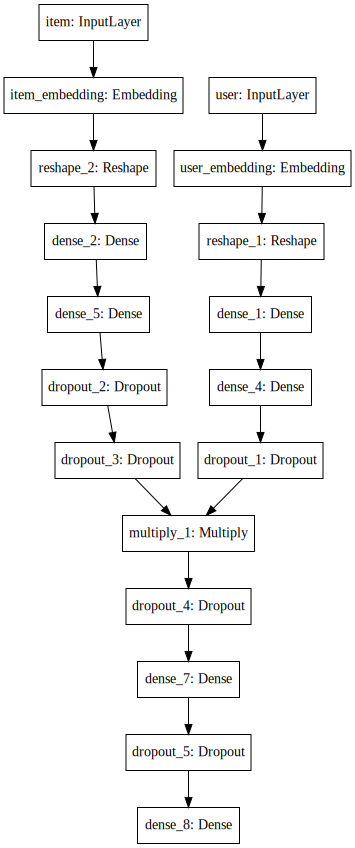

time: 250 ms


In [70]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

,0,1,2,3
loss,2.234523,1.309103,1.033515,0.889537
val_loss,1.573231,1.649413,1.692106,1.733747


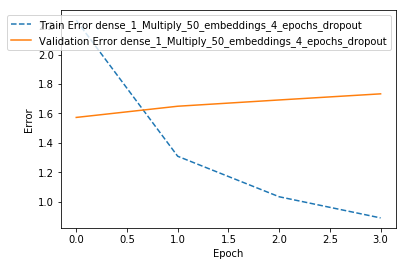

time: 248 ms


In [71]:
x=plt_pickle(hist_path , modname , '.pkl')
x.head(20).transpose()